#### Importing essential libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import  word_tokenize
import re
import string
import numpy as np
from gensim.models import  Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

True

# EDA


In [ ]:
df=pd.read_json('/content/drive/MyDrive/slvyr/News_Category_Dataset_v3.json',lines=True)

In [ ]:
df_co=df.copy()

In [ ]:
df_co.drop(['link','date','authors'],inplace=True,axis=1)

In [ ]:
df_co.head()

,headline,category,short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...


In [ ]:
len(df_co.category.unique())

42

In [ ]:
df_co.isnull().sum()

headline             0
category             0
short_description    0
dtype: int64

<Axes: >

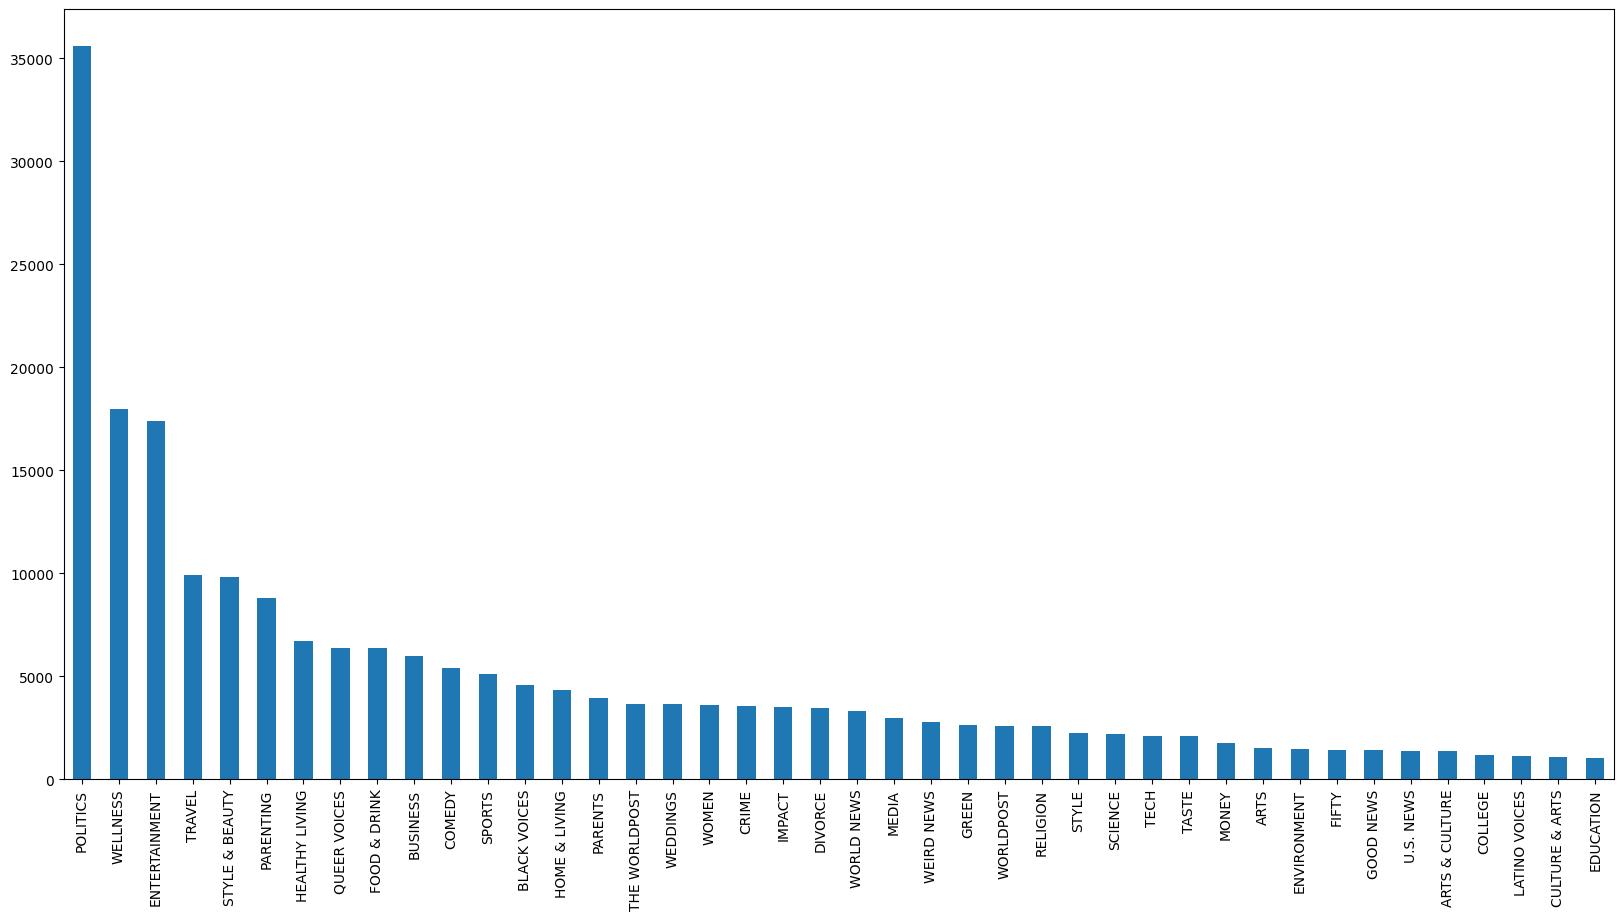

In [ ]:
df_co['category'].value_counts().plot(kind='bar',figsize=(20,10))

In [ ]:
print(df_co[df_co['short_description'].apply(lambda x: len(x)==0)].shape)           #checking the missing data in short descrption


(19712, 3)


In [ ]:
print(df_co[df_co['headline'].apply(lambda x: len(x)==0)].shape)            #checking the missing data in headline

(6, 3)


In [ ]:
print(df_co['category'].nunique())  #checking count of unique values
print(df_co['category'].unique())   #checking unique values

42
['U.S. NEWS' 'COMEDY' 'PARENTING' 'WORLD NEWS' 'CULTURE & ARTS' 'TECH'
 'SPORTS' 'ENTERTAINMENT' 'POLITICS' 'WEIRD NEWS' 'ENVIRONMENT'
 'EDUCATION' 'CRIME' 'SCIENCE' 'WELLNESS' 'BUSINESS' 'STYLE & BEAUTY'
 'FOOD & DRINK' 'MEDIA' 'QUEER VOICES' 'HOME & LIVING' 'WOMEN'
 'BLACK VOICES' 'TRAVEL' 'MONEY' 'RELIGION' 'LATINO VOICES' 'IMPACT'
 'WEDDINGS' 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS'
 'DIVORCE']


In [ ]:
# converting categoried into more generic form by grouping 
mapping = {
    'PARENTING': 'PARENTS',
    'THE WORLDPOST': 'WORLD NEWS',
    'WORLDPOST': 'WORLD NEWS',
    'BLACK VOICES': 'VOICES',
    'QUEER VOICES': 'VOICES',
    'LATINO VOICES': 'VOICES',
    'WEDDINGS': 'WEDDINGS & DIVORCE',
    'DIVORCE': 'WEDDINGS & DIVORCE',
    'HEALTHY LIVING': 'WELLNESS',
    'ARTS & CULTURE': 'CULTURE & ARTS',
    'ARTS': 'CULTURE & ARTS',
    'EDUCATION': 'EDUCATION & SCIENCE',
    'SCIENCE': 'EDUCATION & SCIENCE',
    'MONEY': 'BUSINESS',
    'STYLE': 'STYLE & BEAUTY',
    'TASTE': 'FOOD & DRINK',
    'GREEN': 'ENVIRONMENT'
}
df_co['category'] = df_co['category'].map(mapping).fillna(df_co['category'])


<Axes: >

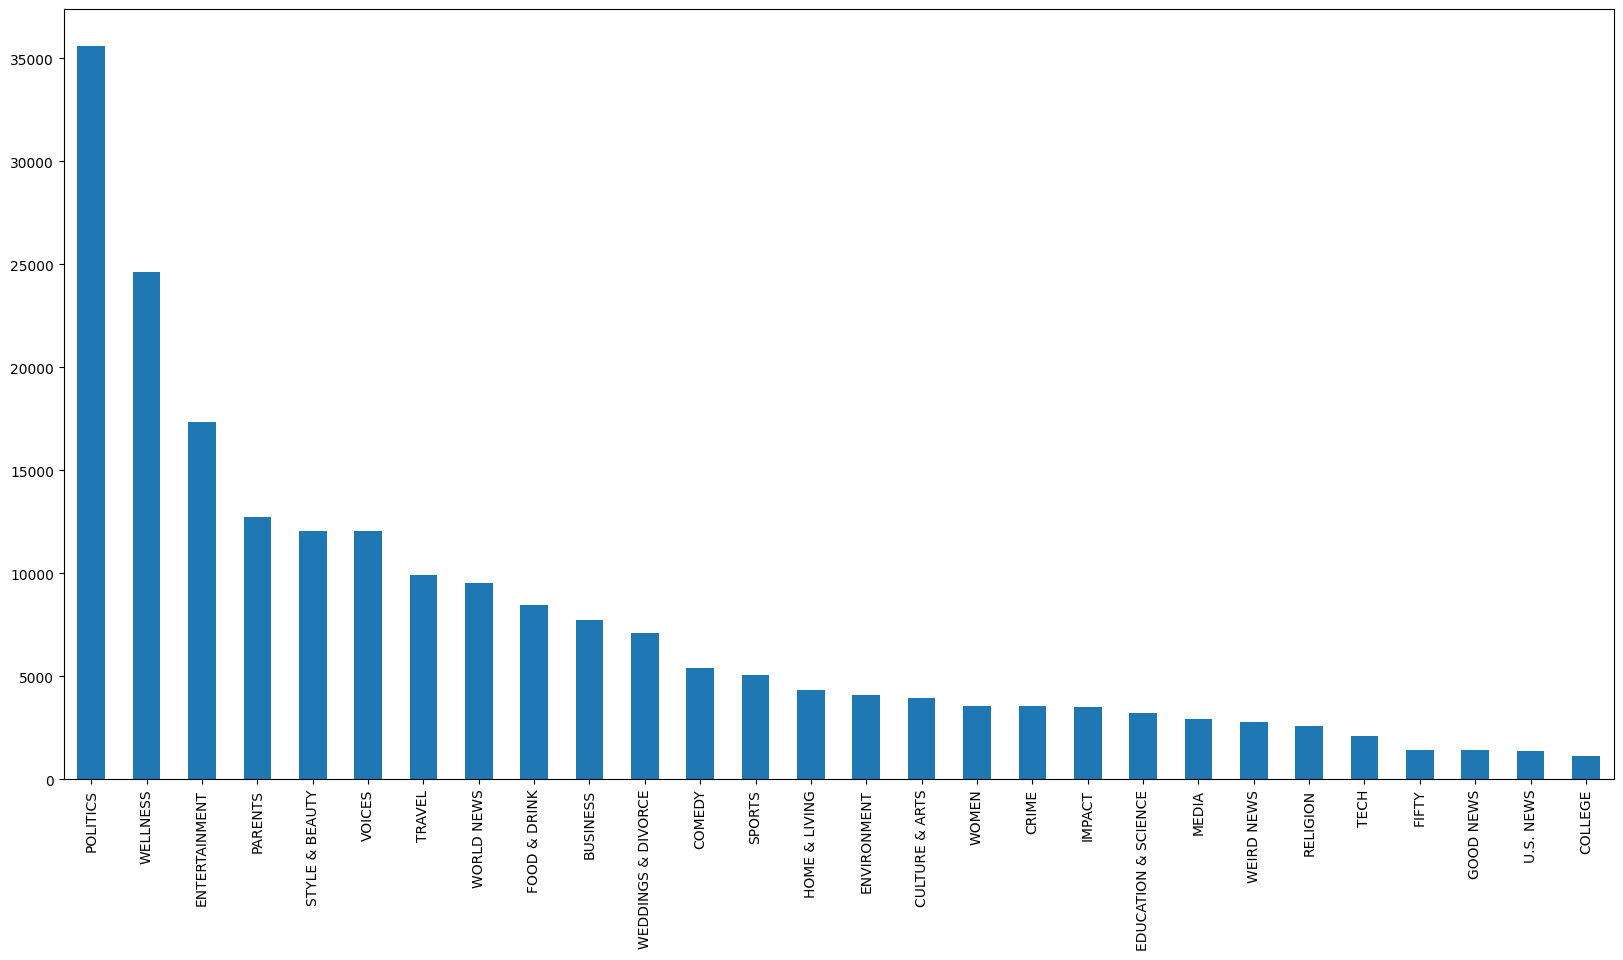

In [ ]:
df_co['category'].value_counts().plot(kind='bar',figsize=(20,10))

In [ ]:
#dropping the null value rows
null_value_rows=df_co[((df_co['short_description'].apply(lambda x: len(x)==0)) & (df_co['headline'].apply(lambda x: len(x)==0)))].index

df_co.drop(null_value_rows,inplace=True)

# Feature engineering

In [ ]:
df_co['Text']=df_co['headline']+' '+df_co['short_description']


In [ ]:
def clean_text(text):                       #creating function which clean the text data
    if len(text)!=0:
        # remove punctuation using string.punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # remove any remaining punctuation using regex
        text = re.sub(r'[^\w\s]', '', text)
        
        # normalizing tokenize words 
        stop_words = set(stopwords.words('english'))
        stemmer=PorterStemmer()
        text = [    stemmer.stem(word)
                    for word in word_tokenize(text) 
                    if stemmer.stem(word) not in stop_words]
        return text
    else:
        return text

In [ ]:
df_co

,headline,category,short_description,Text
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,Over 4 Million Americans Roll Up Sleeves For O...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,"American Airlines Flyer Charged, Banned For Li..."
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",23 Of The Funniest Tweets About Cats And Dogs ...
3,The Funniest Tweets From Parents This Week (Se...,PARENTS,"""Accidentally put grown-up toothpaste on my to...",The Funniest Tweets From Parents This Week (Se...
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Woman Who Called Cops On Black Bird-Watcher Lo...
...,...,...,...,...
209522,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...
209523,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",Maria Sharapova Stunned By Victoria Azarenka I...
209524,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...","Giants Over Patriots, Jets Over Colts Among M..."
209525,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,Aldon Smith Arrested: 49ers Linebacker Busted ...


In [ ]:
df_co['Text']=df_co['Text'].apply(clean_text)
df_co.drop(df_co[(df_co['Text'].apply(lambda x: len(x)==0))].index,inplace=True)

In [ ]:
# df_co.to_csv('/content/drive/MyDrive/slvyr/NCP.csv',index=False)

# Model Training 

In [ ]:
df_co

,headline,category,short_description,Text
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"[4, million, american, roll, sleev, omicrontar..."
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,"[american, airlin, flyer, charg, ban, life, pu..."
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...","[23, funniest, tweet, cat, dog, thi, week, sep..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTS,"""Accidentally put grown-up toothpaste on my to...","[funniest, tweet, parent, thi, week, sept, 172..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,"[woman, call, cop, black, birdwatch, lose, law..."
...,...,...,...,...
209522,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"[rim, ceo, thorsten, hein, signific, plan, bla..."
209523,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...","[maria, sharapova, stun, victoria, azarenka, a..."
209524,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...","[giant, patriot, jet, colt, among, improb, sup..."
209525,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,"[aldon, smith, arrest, 49er, lineback, bust, d..."


In [ ]:
def get_split_ind_dep_feat(df_co):

  # Convert the category labels to numerical values
  le = LabelEncoder()
  y = le.fit_transform(df_co['category'])
  # y = df_co['category']
  
  # creating the word2vec model
  model = Word2Vec(df_co['Text'],vector_size=100 , window=5, min_count=1, workers=4)

  # creating 2D array with taking overall average of the all words vector
  X = np.array([np.mean([model.wv[word] for word in sentence], axis=0) for sentence in df_co['Text']])

  return X,y


In [ ]:
# get prediction in str format

def get_prediction(trained_model,pred_sentence):
  pred=trained_model.predict(sentence)
  le=LabelEncoder()
  pred=le.inverse_transform(pred)
  return pred

In [ ]:
# Convert the category labels to numerical values
le = LabelEncoder()
y = le.fit_transform(df_co['category'])
# y = df_co['category']
# creating the word2vec model
model = Word2Vec(df_co['Text'],vector_size=100 , window=5, min_count=1, workers=4)

# creating 2D array with taking overall average of the all words vector
X = np.array([np.mean([model.wv[word] for word in sentence], axis=0) for sentence in df_co['Text']])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### LightGBM

In [ ]:
import lightgbm as lgb


# # Create LightGBM classifier object
# lgb1 = lgb.LGBMClassifier()

# # Set hyperparameters
# params = {
#     'num_leaves': [11, 21, 31], # Maximum number of leaves in one tree
#     'learning_rate': [0.001, 0.05, 0.1], # Learning rate for boosting
#     'min_data_in_leaf': [20, 25], # Minimum number of data points in a leaf
# }

# # Train the model
# grid_search = GridSearchCV(lgb1, params, n_jobs=-1)  
# grid_search.fit(X_train, y_train)

# # Get the best model and its hyperparameters
# best_model = grid_search.best_estimator_
# best_params = grid_search.best_params_

# # Make predictions on the validation set
# val_preds = best_model.predict(X_test)

# # Evaluate the model on the validation set
# val_auc = roc_auc_score(y_test, val_preds)
# print('==='*30)
# print('Validation AUC:', val_auc)
# print('==='*30)
# print('Best hyperparameters:', best_params)
# print('==='*30)


In [ ]:
# Create LightGBM classifier object
lgb1 = lgb.LGBMClassifier()


# Train the model 
lgb1.fit(X_train,y_train)


# Make predictions on the validation set
pred=lgb1.predict(X_test)

In [ ]:
# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='weighted')
recall = recall_score(y_test, pred, average='weighted')
f1 = f1_score(y_test, pred, average='weighted')
report = classification_report(y_test, pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Classification report:\n", report)

Accuracy: 0.5735729285987018
Precision: 0.5509635521164046
Recall: 0.5735729285987018
F1-score: 0.556592741121488
Classification report:
               precision    recall  f1-score   support

           0       0.45      0.42      0.44      1526
           1       0.20      0.19      0.20       213
           2       0.39      0.24      0.29      1055
           3       0.43      0.45      0.44       742
           4       0.36      0.25      0.29       799
           5       0.39      0.24      0.30       596
           6       0.52      0.64      0.57      3518
           7       0.38      0.28      0.32       816
           8       0.07      0.04      0.05       297
           9       0.70      0.72      0.71      1673
          10       0.15      0.10      0.12       263
          11       0.58      0.56      0.57       862
          12       0.28      0.15      0.19       672
          13       0.35      0.19      0.25       573
          14       0.58      0.65      0.61      25

#### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier



# Create a logistic regression classifier
clf = RandomForestClassifier()

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred_RF = clf.predict(X_test)



In [ ]:

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred_RF)
precision = precision_score(y_test, y_pred_RF, average='weighted')
recall = recall_score(y_test, y_pred_RF, average='weighted')
f1 = f1_score(y_test, y_pred_RF, average='weighted')
report = classification_report(y_test, y_pred_RF)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Classification report:\n", report)

Accuracy: 0.5537896143566247
Precision: 0.5472819067510895
Recall: 0.5537896143566247
F1-score: 0.5096660681962769
Classification report:
               precision    recall  f1-score   support

           0       0.46      0.34      0.39      1526
           1       0.37      0.03      0.06       213
           2       0.54      0.13      0.21      1055
           3       0.48      0.51      0.50       742
           4       0.51      0.16      0.25       799
           5       0.44      0.06      0.11       596
           6       0.45      0.70      0.55      3518
           7       0.53      0.17      0.26       816
           8       0.00      0.00      0.00       297
           9       0.67      0.71      0.69      1673
          10       0.22      0.01      0.01       263
          11       0.67      0.44      0.53       862
          12       0.44      0.03      0.05       672
          13       0.56      0.07      0.12       573
          14       0.51      0.63      0.56      2

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: 

#### Multi layer Perceptron classifier (MLPclassifier)

In [ ]:
from sklearn.neural_network import MLPClassifier
# creating MLPclassifier object 
MLP = MLPClassifier()
# training model 
MLP.fit(X_train,y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [ ]:
# predicting validation dataset

pred_MLP = MLP.predict(X_test)

In [ ]:
# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, pred_MLP)
precision = precision_score(y_test, pred_MLP, average='weighted')
recall = recall_score(y_test, pred_MLP, average='weighted')
f1 = f1_score(y_test, pred_MLP, average='weighted')
report = classification_report(y_test, pred_MLP)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Classification report:\n", report)

Accuracy: 0.6067201221840397
Precision: 0.5867773715534744
Recall: 0.6067201221840397
F1-score: 0.5916038190172036
Classification report:
               precision    recall  f1-score   support

           0       0.51      0.46      0.48      1526
           1       0.35      0.26      0.30       213
           2       0.39      0.27      0.32      1055
           3       0.51      0.49      0.50       742
           4       0.40      0.31      0.35       799
           5       0.39      0.35      0.37       596
           6       0.57      0.64      0.60      3518
           7       0.42      0.34      0.38       816
           8       0.24      0.02      0.04       297
           9       0.70      0.77      0.73      1673
          10       0.26      0.16      0.20       263
          11       0.64      0.61      0.62       862
          12       0.37      0.16      0.22       672
          13       0.42      0.25      0.32       573
          14       0.62      0.68      0.65      2

#### Support vector machine

In [ ]:
# creating SVM model 
from sklearn.svm import SVC




# Train the SVM classifier with hyperparameter tuning

# tuned_parameters = {'kernel': ['linear', 'rbf', 'poly'], 'C': [1, 10, 100]}
# clf = GridSearchCV(SVC(), tuned_parameters, cv=5)

clf = SVC()
clf.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
# SVM 58%

#### XGBoost

In [ ]:

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import xgboost as xgb


# # Use GPU acceleration with XGBoost
# # xgb_params = {'tree_method': 'gpu_hist'}
# xgb_clf = xgb.XGBClassifier()

# # Use early stopping to avoid overfitting
# # xgb_params.update({'eval_metric': 'auc', 'early_stopping_rounds': 10})
# # xgb_clf = XGBClassifier(**xgb_params)

# # Use grid search to optimize hyperparameters


# # param_grid = {'n_estimators': [100,200,300],
# #               'max_depth': [3,6],
# #               'learning_rate': [0.01,0.1,],
# #               'subsample': [0.6,0.8],
# #               'colsample_bytree': [0.6,0.8],
# #               'gamma': [0,0.1,]}
# # grid_search = GridSearchCV(xgb_clf, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=3)
# # grid_search.fit(X_train, y_train)
# # best_model = grid_search.best_estimator_

# # Evaluate the best model on the test set
# xgb_clf.fit(X_train,y_train)
# y_pred = xgb_clf.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.3f}")


# # Plotting feature performance 
# xgb.plot_importance(xgb_clf)
# plt.show()

In [ ]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")
